In [1]:
import pickle
import numpy as np
from torchvision.transforms import Resize
from PIL import Image
import h5py
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

import matplotlib; matplotlib.use('Agg')
import torch
import os
import time
from shutil import copy
import datetime
import imp

import matplotlib; matplotlib.use('Agg')
import torch
import os
import time
from shutil import copy
import datetime
import imp
from tensorboardX import SummaryWriter
import numpy as np
import random
from torch import autograd
from torch.optim import Adam, RMSprop, SGD
from functools import partial


class AttrDict(dict):
    __setattr__ = dict.__setitem__

    def __getattr__(self, attr):
        # Take care that getattr() raises AttributeError, not KeyError.
        # Required e.g. for hasattr(), deepcopy and OrderedDict.
        try:
            return self.__getitem__(attr)
        except KeyError:
            raise AttributeError("Attribute %r not found" % attr)

    def __getstate__(self):
        return self

    def __setstate__(self, d):
        self = d
        
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 2 to use

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_915673/3269413979.py:20: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
# load train dataset
with open('train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
train_data.keys()

dict_keys(['actions', 'conc_images', 'next_conc_images', 'ylabel'])

In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

# CNN that receives state
class Rsnet(nn.Module): #C
    def __init__(self):
        super(Rsnet, self).__init__()
        
        # state : (32, 32, 3)
        # state : (128, 60) -> phi(st) : (128, 288)
        self.conv1 = nn.Conv2d(6, 8, kernel_size=(4,4), stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(4,4), stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(4,4), stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(4,4), stride=1)
        self.linear5 = nn.Linear(32,1)

    def forward(self,x):
        # torch.Size([128, 2, 3, 32, 32])
        #x = F.normalize(x)

        # torch.Size([128, 32, 2, 16, 16])
        y = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        y = F.leaky_relu(self.bn2(self.conv2(y)), negative_slope=0.2, inplace=True)
        y = F.leaky_relu(self.bn3(self.conv3(y)), negative_slope=0.2, inplace=True)
        y = self.conv4(y)
        
        # torch.Size([128, 34])
        y = y.flatten(start_dim=1)
        y = self.linear5(y)
        
        return y

In [5]:
# load NN

rsnet = Rsnet().to("cuda")
rs_loss  = nn.MSELoss(reduction='none')

all_model_params = list(rsnet.parameters()) #A
opt = optim.Adam(lr=0.001, params=all_model_params)

In [6]:
# batch train
def minibatch_train(use_extrinsic=True):

    # sample batch
    one_batch_indexes = list(np.random.randint(0, train_data['actions'].shape[0]-1, size=128))
    batch_conc_images = train_data['conc_images'][one_batch_indexes]
    #batch_next_conc_images = train_data['next_conc_images'][one_batch_indexes]
    #batch_actions = train_data['actions'][one_batch_indexes]
    #batch_ylabel = train_data['ylabel'][one_batch_indexes]
    
    state1_batch = torch.from_numpy(batch_conc_images).to("cuda")
    #state2_batch = torch.from_numpy(batch_next_conc_images)
    #action_batch = torch.from_numpy(batch_actions)


    # correct ylabel
    #ylabel_batch = batch_ylabel.to("cuda")

    # baseline model only using state 
    rs_pred = rsnet(state1_batch)
    
    # calculat eloss
    rs_pred_err = rs_loss(rs_pred, ylabel_batch)
    
    return rs_pred_err


def loss_fn(rs_pred_err):
    loss_ = rs_pred_err

    loss = loss_.sum() / loss_.flatten().shape[0]
    return loss

In [7]:
from tqdm import tqdm

epochs = 10000

eps=0.15
losses = []
episode_length = 0

ep_lengths = []
use_explicit = False

i_reward_list = []


for i in tqdm(range(epochs)):
    opt.zero_grad()

    rs_pred_err = minibatch_train(use_extrinsic=False) #H
    loss = loss_fn(rs_pred_err) #I
    loss_list = (rs_pred_err.flatten().mean())
    
    losses.append(loss_list)
    loss.backward()
    opt.step()

    
    print
    if i % 100 == 0:
        loss = loss.item()
        print(f"loss: {loss:>7f}")
        #print(i_reward)
    

  0%|          | 17/10000 [00:03<21:37,  7.70it/s] 

loss: 178.309509


  1%|          | 124/10000 [00:03<01:44, 94.36it/s]

loss: 49.269211


  2%|▏         | 215/10000 [00:04<01:21, 119.67it/s]

loss: 45.837437


  3%|▎         | 319/10000 [00:05<01:17, 124.15it/s]

loss: 39.622299


  4%|▍         | 423/10000 [00:06<01:16, 125.94it/s]

loss: 43.735928


  5%|▌         | 515/10000 [00:07<01:18, 121.33it/s]

loss: 48.683235


  6%|▌         | 621/10000 [00:07<01:14, 126.51it/s]

loss: 41.968410


  7%|▋         | 722/10000 [00:08<01:12, 128.38it/s]

loss: 281.931793


  8%|▊         | 822/10000 [00:09<01:11, 128.75it/s]

loss: 34.393208


  9%|▉         | 926/10000 [00:10<01:11, 126.63it/s]

loss: 42.668472


 10%|█         | 1017/10000 [00:10<01:12, 123.64it/s]

loss: 59.928452


 11%|█         | 1121/10000 [00:11<01:12, 123.25it/s]

loss: 33.745605


 12%|█▏        | 1225/10000 [00:12<01:10, 124.05it/s]

loss: 45.760895


 13%|█▎        | 1316/10000 [00:13<01:09, 124.48it/s]

loss: 24.454353


 14%|█▍        | 1419/10000 [00:14<01:15, 113.50it/s]

loss: 44.046188


 15%|█▌        | 1520/10000 [00:15<01:08, 123.11it/s]

loss: 50.865078


 16%|█▋        | 1626/10000 [00:15<01:05, 128.39it/s]

loss: 31.318214


 17%|█▋        | 1720/10000 [00:16<01:03, 129.49it/s]

loss: 45.411850


 18%|█▊        | 1824/10000 [00:17<01:06, 122.11it/s]

loss: 56.558758


 19%|█▉        | 1915/10000 [00:18<01:06, 122.31it/s]

loss: 36.838234


 20%|██        | 2019/10000 [00:19<01:03, 125.72it/s]

loss: 42.109699


 21%|██        | 2123/10000 [00:19<01:03, 124.14it/s]

loss: 34.849022


 22%|██▏       | 2212/10000 [00:20<01:08, 112.95it/s]

loss: 33.481682


 23%|██▎       | 2322/10000 [00:21<00:58, 130.75it/s]

loss: 29.780209


 24%|██▍       | 2419/10000 [00:22<00:57, 130.98it/s]

loss: 34.479393


 25%|██▌       | 2524/10000 [00:23<01:01, 121.45it/s]

loss: 32.367783


 26%|██▌       | 2624/10000 [00:23<01:01, 119.86it/s]

loss: 21.063190


 27%|██▋       | 2718/10000 [00:24<00:57, 126.89it/s]

loss: 30.146851


 28%|██▊       | 2822/10000 [00:25<00:56, 127.88it/s]

loss: 35.342670


 29%|██▉       | 2913/10000 [00:26<01:01, 114.79it/s]

loss: 32.666580


 30%|███       | 3014/10000 [00:27<00:56, 123.23it/s]

loss: 29.091488


 31%|███       | 3119/10000 [00:27<00:54, 126.08it/s]

loss: 22.537552


 32%|███▏      | 3214/10000 [00:28<00:52, 130.25it/s]

loss: 28.927097


 33%|███▎      | 3318/10000 [00:29<00:56, 117.33it/s]

loss: 22.744484


 34%|███▍      | 3423/10000 [00:30<00:51, 127.91it/s]

loss: 41.749195


 35%|███▌      | 3514/10000 [00:31<00:51, 125.97it/s]

loss: 28.438923


 36%|███▌      | 3619/10000 [00:31<00:49, 127.91it/s]

loss: 28.555687


 37%|███▋      | 3717/10000 [00:32<00:49, 128.03it/s]

loss: 37.108105


 38%|███▊      | 3819/10000 [00:33<00:43, 141.47it/s]

loss: 22.175304


 39%|███▉      | 3917/10000 [00:34<00:47, 127.09it/s]

loss: 17.238302


 40%|████      | 4021/10000 [00:35<00:46, 128.06it/s]

loss: 18.434114


 41%|████      | 4114/10000 [00:35<00:46, 125.97it/s]

loss: 19.689075


 42%|████▏     | 4220/10000 [00:36<00:45, 126.06it/s]

loss: 20.743507


 43%|████▎     | 4322/10000 [00:37<00:48, 118.09it/s]

loss: 21.684654


 44%|████▍     | 4426/10000 [00:38<00:44, 126.58it/s]

loss: 17.953732


 45%|████▌     | 4518/10000 [00:38<00:43, 126.12it/s]

loss: 18.293303


 46%|████▌     | 4622/10000 [00:39<00:43, 123.41it/s]

loss: 20.679493


 47%|████▋     | 4726/10000 [00:40<00:42, 123.44it/s]

loss: 28.250900


 48%|████▊     | 4817/10000 [00:41<00:42, 122.71it/s]

loss: 16.887524


 49%|████▉     | 4916/10000 [00:42<00:42, 119.13it/s]

loss: 17.036236


 50%|█████     | 5020/10000 [00:43<00:39, 126.80it/s]

loss: 17.305202


 51%|█████     | 5124/10000 [00:43<00:38, 127.09it/s]

loss: 19.911161


 52%|█████▏    | 5221/10000 [00:44<00:36, 129.95it/s]

loss: 17.707989


 53%|█████▎    | 5326/10000 [00:45<00:37, 124.15it/s]

loss: 15.208542


 54%|█████▍    | 5417/10000 [00:46<00:37, 123.34it/s]

loss: 17.587719


 55%|█████▌    | 5521/10000 [00:47<00:36, 123.58it/s]

loss: 19.737202


 56%|█████▋    | 5626/10000 [00:47<00:34, 127.84it/s]

loss: 16.978302


 57%|█████▋    | 5724/10000 [00:48<00:32, 130.10it/s]

loss: 23.728474


 58%|█████▊    | 5816/10000 [00:49<00:33, 124.82it/s]

loss: 19.737104


 59%|█████▉    | 5920/10000 [00:50<00:32, 126.14it/s]

loss: 10.470494


 60%|██████    | 6015/10000 [00:50<00:30, 128.97it/s]

loss: 10.883913


 61%|██████▏   | 6125/10000 [00:51<00:29, 130.21it/s]

loss: 14.731665


 62%|██████▏   | 6220/10000 [00:52<00:29, 126.63it/s]

loss: 11.921078


 63%|██████▎   | 6325/10000 [00:53<00:28, 129.64it/s]

loss: 21.787491


 64%|██████▍   | 6420/10000 [00:54<00:27, 129.39it/s]

loss: 18.827602


 65%|██████▌   | 6525/10000 [00:54<00:27, 127.30it/s]

loss: 19.226746


 66%|██████▌   | 6616/10000 [00:55<00:28, 118.43it/s]

loss: 11.525752


 67%|██████▋   | 6722/10000 [00:56<00:25, 128.26it/s]

loss: 10.197275


 68%|██████▊   | 6818/10000 [00:57<00:24, 128.17it/s]

loss: 13.784101


 69%|██████▉   | 6922/10000 [00:58<00:24, 127.83it/s]

loss: 13.386370


 70%|███████   | 7019/10000 [00:58<00:21, 136.19it/s]

loss: 13.819084


 71%|███████   | 7117/10000 [00:59<00:22, 129.87it/s]

loss: 15.327177


 72%|███████▏  | 7222/10000 [01:00<00:21, 129.08it/s]

loss: 10.819180


 73%|███████▎  | 7319/10000 [01:01<00:20, 132.07it/s]

loss: 9.091661


 74%|███████▍  | 7415/10000 [01:01<00:19, 129.86it/s]

loss: 19.080257


 75%|███████▌  | 7511/10000 [01:02<00:20, 121.47it/s]

loss: 13.734632


 76%|███████▌  | 7618/10000 [01:03<00:18, 128.59it/s]

loss: 12.855387


 77%|███████▋  | 7723/10000 [01:04<00:17, 126.92it/s]

loss: 18.582066


 78%|███████▊  | 7826/10000 [01:05<00:17, 122.93it/s]

loss: 14.514900


 79%|███████▉  | 7922/10000 [01:05<00:15, 130.01it/s]

loss: 8.522379


 80%|████████  | 8014/10000 [01:06<00:15, 127.66it/s]

loss: 11.527609


 81%|████████  | 8115/10000 [01:07<00:13, 135.68it/s]

loss: 12.405981


 82%|████████▏ | 8220/10000 [01:08<00:14, 124.46it/s]

loss: 10.600093


 83%|████████▎ | 8324/10000 [01:09<00:13, 124.00it/s]

loss: 8.815856


 84%|████████▍ | 8415/10000 [01:09<00:12, 126.58it/s]

loss: 10.065558


 85%|████████▌ | 8519/10000 [01:10<00:11, 124.63it/s]

loss: 10.465660


 86%|████████▌ | 8623/10000 [01:11<00:10, 127.39it/s]

loss: 7.286202


 87%|████████▋ | 8714/10000 [01:12<00:10, 122.69it/s]

loss: 9.500832


 88%|████████▊ | 8825/10000 [01:13<00:09, 129.75it/s]

loss: 9.357031


 89%|████████▉ | 8916/10000 [01:13<00:08, 123.53it/s]

loss: 10.170024


 90%|█████████ | 9020/10000 [01:14<00:08, 120.79it/s]

loss: 8.223597


 91%|█████████ | 9122/10000 [01:15<00:07, 118.18it/s]

loss: 8.055197


 92%|█████████▏| 9214/10000 [01:16<00:06, 128.18it/s]

loss: 9.310260


 93%|█████████▎| 9324/10000 [01:17<00:05, 129.22it/s]

loss: 7.515399


 94%|█████████▍| 9415/10000 [01:17<00:04, 128.16it/s]

loss: 10.479914


 95%|█████████▌| 9519/10000 [01:18<00:03, 126.79it/s]

loss: 9.391445


 96%|█████████▌| 9623/10000 [01:19<00:03, 123.70it/s]

loss: 8.111248


 97%|█████████▋| 9714/10000 [01:20<00:02, 126.07it/s]

loss: 6.181479


 98%|█████████▊| 9818/10000 [01:20<00:01, 123.75it/s]

loss: 10.713177


 99%|█████████▉| 9925/10000 [01:21<00:00, 129.59it/s]

loss: 8.496597


100%|██████████| 10000/10000 [01:22<00:00, 121.42it/s]


In [8]:
# save model
#torch.save(rsnet.state_dict(), "spirl/baseline_rsnet")

In [9]:
# test your model with validation dataset
rsnet = Rsnet().eval()
rsnet.load_state_dict(torch.load("spirl/baseline_rsnet"))
rsnet.to("cuda")

Rsnet(
  (conv1): Conv2d(6, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (linear5): Linear(in_features=32, out_features=1, bias=True)
)

In [10]:
# load val dataset
with open('val_data.pickle', 'rb') as f:
    val_data = pickle.load(f)

In [13]:
# predict ylabel
val_conc_images = val_data['conc_images']
state1_val = torch.from_numpy(val_conc_images).to("cuda")


with torch.no_grad():
    y_pred = rsnet(state1_val)

In [30]:
y_pred_list_rsnet = [y_pred[i].item() for i in range(0, len(y_pred))]
y_true = val_data['ylabel'].to("cuda")

In [32]:
# Compute prediction loss
pred_loss  = nn.MSELoss(reduction='none').to("cuda")
pred_loss = pred_loss(y_pred, y_true)
pred_loss = pred_loss.sum() / pred_loss.flatten().shape[0]
print(pred_loss)


tensor(92.7164, device='cuda:0')


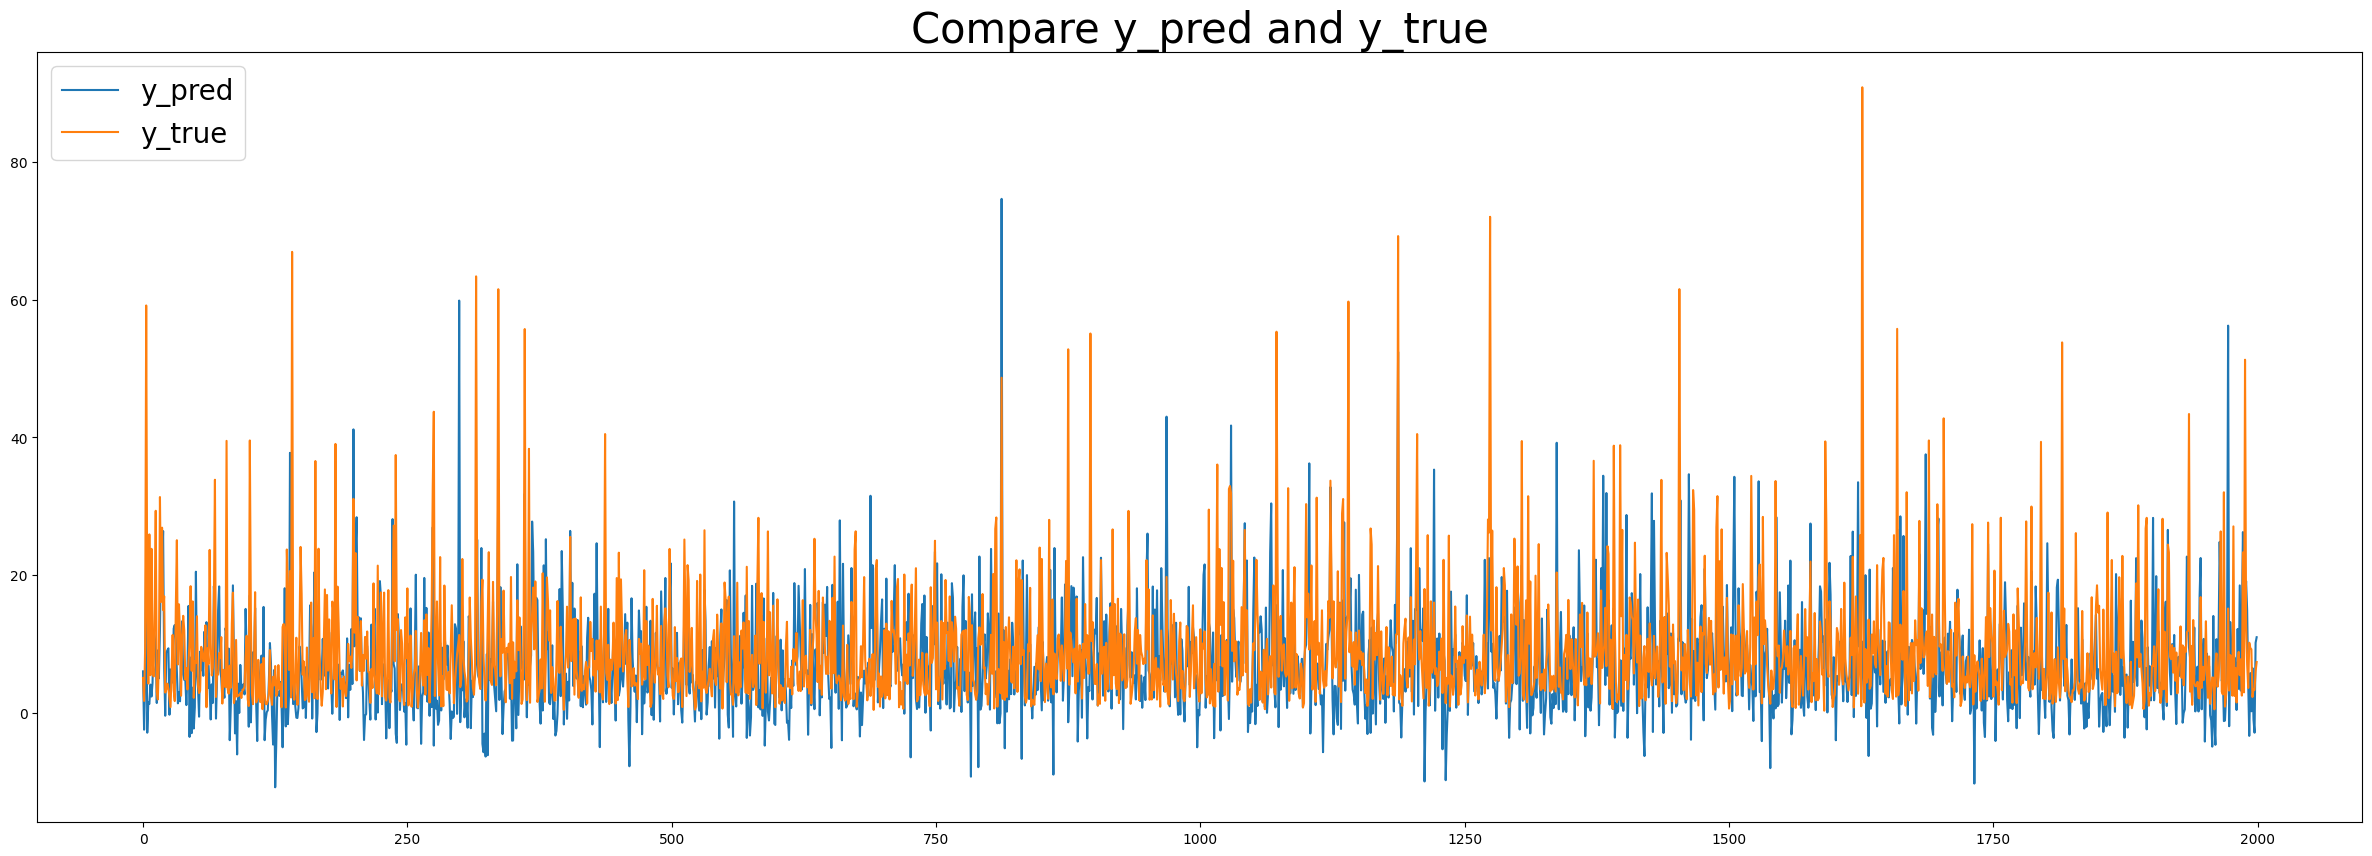

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(30,10))
plt.plot(range(0, len(y_pred_list_rsnet)), y_pred_list_rsnet, label="y_pred")
plt.plot(range(0, len(y_true)), val_data['ylabel'], label="y_true")

plt.title("Compare y_pred and y_true", size=30)
plt.legend(loc='upper left', fontsize="20")
plt.show()